In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#def softmax(z): return np.exp(z)/((np.exp(z)).sum())

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def total_loss(y_true, y_pred):
    return (contrastive_loss(y_true, y_pred) + 0.05*kullback_leibler_divergence(y_true, y_pred))

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.2))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.epsilon()

1e-07

In [3]:
seed=7
numpy.random.seed(seed)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_test = X_test.astype('float32')

In [5]:
X_train=list(X_train)
for i in range(0,10):
    for j in range(201,216):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_train.append(arr)
X_train=np.array(X_train)
X_train=X_train.reshape(60150,784)
X_train=X_train.astype('float32')

print(X_train.shape)

(60150, 784)


In [6]:
#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

print(X_train.shape)
print(X_test.shape)

(60150, 784)
(10000, 784)


In [7]:
X_train=X_train/255
X_test=X_test/255

In [8]:
y_train=list(y_train)

for i in range(0,10):
    for j in range(201,216):
        y_train.append(i)
        
y_train=np.array(y_train)

num_classes = 10
print(y_train.shape)
print(y_test.shape)

(60150,)
(10000,)


In [9]:
print(y_train)
print(X_train.max())

[5 0 4 ... 9 9 9]
1.0


In [10]:
input_dim = 784
nb_epoch = 20

In [11]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [57]:
print(te_y.shape)

(17820,)


In [58]:
print(te_pairs.shape)

(17820, 2, 784)


In [12]:
base_network = create_base_network()

In [13]:

X_temp=X_train.reshape(-1,28,28,1)
input_dim = X_temp.shape[1:]
print(input_dim)

(28, 28, 1)


In [14]:

# network definition
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

(?, 28, 28, 1)


In [15]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)


In [16]:
print(processed_a.shape)

(?, 128)


In [64]:
loss_AtoB = kullback_leibler_divergence(processed_a,processed_b)
loss_BtoA = kullback_leibler_divergence(processed_b,processed_a)

print(loss_AtoB)

Tensor("Sum_2:0", shape=(?,), dtype=float32)


In [65]:
klDivergence_loss = loss_AtoB + loss_BtoA
print(klDivergence_loss.shape)

(?,)


In [17]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])


model = Model(input=[input_a, input_b], output=distance)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  after removing the cwd from sys.path.


In [18]:
print(distance.shape)

(?, 1)


In [19]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [20]:
tr_pairs1=tr_pairs.reshape(-1,2,28,28,1)
te_pairs1=te_pairs.reshape(-1,2,28,28,1)

print(tr_pairs1.shape)
print(te_pairs1.shape)

(108700, 2, 28, 28, 1)
(17820, 2, 28, 28, 1)


In [70]:
print(tr_pairs1[:,0].shape)

(108700, 28, 28, 1)


In [71]:
print(tr_pairs[:, 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


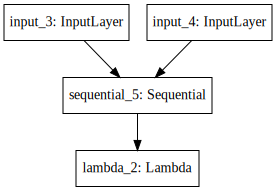

In [72]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

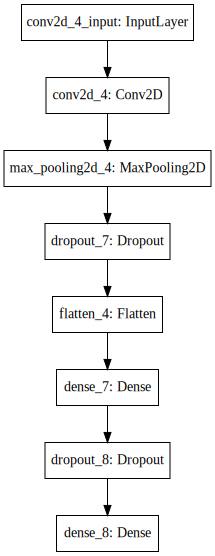

In [73]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_network).create(prog='dot', format='svg'))

In [119]:
nb_epoch=10

In [21]:
# train 10 epochs
rms = RMSprop()
model.compile(loss= total_loss , optimizer=rms)
history = model.fit([tr_pairs1[:,0], tr_pairs1[:, 1]], tr_y,
          validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 108700 samples, validate on 17820 samples
Epoch 1/20
108700/108700 [==============================] - 82s 754us/step - loss: 0.0984 - val_loss: 0.0756
Epoch 2/20
108700/108700 [==============================] - 77s 713us/step - loss: 0.0720 - val_loss: 0.0720
Epoch 3/20
108700/108700 [==============================] - 79s 726us/step - loss: 0.0680 - val_loss: 0.0712
Epoch 4/20
108700/108700 [==============================] - 77s 710us/step - loss: 0.0661 - val_loss: 0.0702
Epoch 5/20
108700/108700 [==============================] - 77s 707us/step - loss: 0.0653 - val_loss: 0.0703
Epoch 6/20
108700/108700 [==============================] - 78s 716us/step - loss: 0.0645 - val_loss: 0.0701
Epoch 7/20
108700/108700 [==============================] - 76s 701us/step - loss: 0.0641 - val_loss: 0.0696
Epoch 8/20
108700/108700 [==============================] - 74s 684us/step - loss: 0.0637 - val_loss: 0.0698
Epoch 9/20
108700/108700 [==============================] - 74s 684us/step - 

In [120]:
# train
rms = RMSprop()
model.compile(loss= total_loss , optimizer=rms)
history = model.fit([tr_pairs1[:,0], tr_pairs1[:, 1]], tr_y,
          validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 108700 samples, validate on 17820 samples
Epoch 1/20
108700/108700 [==============================] - 83s 765us/step - loss: 0.4276 - val_loss: 0.4571
Epoch 2/20
108700/108700 [==============================] - 82s 752us/step - loss: 0.4274 - val_loss: 0.4563
Epoch 3/20
108700/108700 [==============================] - 82s 754us/step - loss: 0.4273 - val_loss: 0.4553
Epoch 4/20
108700/108700 [==============================] - 82s 754us/step - loss: 0.4272 - val_loss: 0.4480
Epoch 5/20
108700/108700 [==============================] - 80s 732us/step - loss: 0.4271 - val_loss: 0.4568
Epoch 6/20
108700/108700 [==============================] - 74s 683us/step - loss: 0.4270 - val_loss: 0.4519
Epoch 7/20
108700/108700 [==============================] - 74s 684us/step - loss: 0.4269 - val_loss: 0.4528
Epoch 8/20
108700/108700 [==============================] - 74s 683us/step - loss: 0.4269 - val_loss: 0.4458
Epoch 9/20
108700/108700 [==============================] - 74s 684us/step - 

In [26]:
model.save('Siamese+Conv_Train-mnist_150usps_Test-usps.hf')

In [49]:
model.save('Siamese+Conv_Train-mnist_150usps_Test-usps.h5')

In [76]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [101]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs1[:,0], tr_pairs1[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs1[:,0], te_pairs1[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 100.00%
* Accuracy on test set: 100.00%


In [22]:
# compute final accuracy on training and test sets # most recent
pred = model.predict([tr_pairs1[:,0], tr_pairs1[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs1[:,0], te_pairs1[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 100.00%
* Accuracy on test set: 99.86%


In [121]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs1[:,0], tr_pairs1[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs1[:,0], te_pairs1[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 100.00%
* Accuracy on test set: 100.00%


In [102]:
te_y[pred.ravel() < 0.5].mean()

1.0

In [103]:
print(te_y)

[1 0 1 ... 0 1 0]


In [105]:
print(pred.max())

1.4079148


In [23]:
y_test1=[]
for i in range(0,10):
    for j in range(1,201):
        y_test1.append(i)
y_test1=np.array(y_test1)
print(y_test1.size)
print(y_test1)

2000
[0 0 0 ... 9 9 9]


In [24]:
X_test1=[]
for i in range(0,10):
    for j in range(1,201):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_test1.append(arr)
X_test1=np.array(X_test1)
print(X_test1.shape)
print(X_test.shape)

(2000, 784)
(10000, 784)


In [25]:
X_test1 = X_test1.reshape(2000, 784)
X_test1 = X_test1.astype('float32')
X_test1 /= 255
print(X_test.shape)


digit_indices = [np.where(y_test1 == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test1, digit_indices)

(10000, 784)


In [26]:
te_pairs2=te_pairs.reshape(-1,2,28,28,1)

print(te_pairs2.shape)

(3980, 2, 28, 28, 1)


In [27]:
pred = model.predict([te_pairs2[:, 0], te_pairs2[:, 1]])
te_acc = compute_accuracy(pred, te_y)

# compute accuracy on new USPS dataset to check degree of transfer learning
# model only trained on MNIST dataset
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on test set: 88.44%


In [28]:
%matplotlib inline

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

In [29]:
def plot_embedding(mu, Y, title=None):
    num_class = 1000 # data points per class
#     x_min, x_max = np.min(mu, 0), np.max(mu, 0)
#     mu = (mu - x_min) / (x_max - x_min)
    
#     classes = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 
#                20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 48, 49]
    
    classes = [0,1,2,3,4,5,6,7,8,9]
    data = [[] for i in classes]
    for i, y in enumerate(Y):
        data[classes.index(y)].append(np.array(mu[i]))
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple']
    l = [i for i in range(10)]
    alphas = 0.3 * np.ones(10)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(10):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9]), 
               ('0','1','2','3','4','5','6','7','8','9'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

In [30]:
X_test1=X_test1.reshape(-1,28,28,1)

In [31]:
test_model.compile(loss=contrastive_loss, optimizer=rms)
processed=test_model.predict(X_test1)

Computing t-SNE embedding


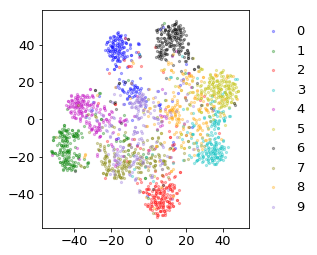

In [96]:
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


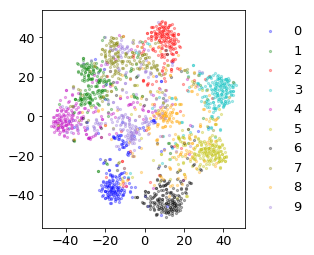

In [129]:
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


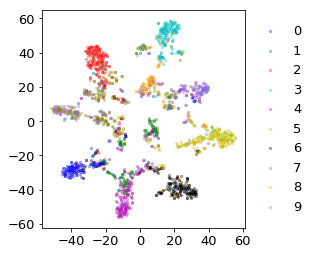

In [32]:
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

In [33]:
X_train11=X_train.reshape(-1,28,28,1)
X_test11=X_test.reshape(-1,28,28,1)

In [34]:
processed_train=test_model.predict(X_train11)
processed_test=test_model.predict(X_test11)

In [35]:
num_pixels = 128
processed_train = processed_train.reshape(processed_train.shape[0], num_pixels).astype('float32')
processed_test = processed_test.reshape(processed_test.shape[0], num_pixels).astype('float32')

print(num_pixels)
print(processed_train.shape)
print(processed_test.shape)

128
(60150, 128)
(10000, 128)


In [36]:
from keras.utils import np_utils
y_train1 = np_utils.to_categorical(y_train)
y_test1 = np_utils.to_categorical(y_test)
num_classes = 10

In [37]:
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [111]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train1, validation_data=(processed_test, y_test1), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores_test = model1.evaluate(processed_test, y_test1, verbose=1)
scores_train = model1.evaluate(processed_train, y_train1, verbose=1)


Train on 60150 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.7087 - acc: 0.9637 - val_loss: 0.0825 - val_acc: 0.9860
Epoch 2/10
 - 1s - loss: 0.0417 - acc: 0.9934 - val_loss: 0.0516 - val_acc: 0.9862
Epoch 3/10
 - 1s - loss: 0.0271 - acc: 0.9938 - val_loss: 0.0457 - val_acc: 0.9865
Epoch 4/10
 - 1s - loss: 0.0230 - acc: 0.9940 - val_loss: 0.0445 - val_acc: 0.9870
Epoch 5/10
 - 1s - loss: 0.0210 - acc: 0.9942 - val_loss: 0.0440 - val_acc: 0.9861
Epoch 6/10
 - 1s - loss: 0.0197 - acc: 0.9944 - val_loss: 0.0428 - val_acc: 0.9866
Epoch 7/10
 - 1s - loss: 0.0188 - acc: 0.9947 - val_loss: 0.0419 - val_acc: 0.9872
Epoch 8/10
 - 1s - loss: 0.0181 - acc: 0.9948 - val_loss: 0.0421 - val_acc: 0.9876
Epoch 9/10
 - 1s - loss: 0.0176 - acc: 0.9949 - val_loss: 0.0428 - val_acc: 0.9875
Epoch 10/10
 - 1s - loss: 0.0171 - acc: 0.9950 - val_loss: 0.0421 - val_acc: 0.9876
60150/60150 [==============================] - 1s 19us/step


In [135]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train1, validation_data=(processed_test, y_test1), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores_test = model1.evaluate(processed_test, y_test1, verbose=1)
scores_train = model1.evaluate(processed_train, y_train1, verbose=1)


Train on 60150 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.7673 - acc: 0.9597 - val_loss: 0.0905 - val_acc: 0.9849
Epoch 2/10
 - 1s - loss: 0.0367 - acc: 0.9961 - val_loss: 0.0541 - val_acc: 0.9848
Epoch 3/10
 - 1s - loss: 0.0203 - acc: 0.9962 - val_loss: 0.0489 - val_acc: 0.9850
Epoch 4/10
 - 1s - loss: 0.0161 - acc: 0.9964 - val_loss: 0.0473 - val_acc: 0.9857
Epoch 5/10
 - 1s - loss: 0.0141 - acc: 0.9965 - val_loss: 0.0478 - val_acc: 0.9851
Epoch 6/10
 - 1s - loss: 0.0130 - acc: 0.9966 - val_loss: 0.0476 - val_acc: 0.9857
Epoch 7/10
 - 1s - loss: 0.0122 - acc: 0.9970 - val_loss: 0.0483 - val_acc: 0.9858
Epoch 8/10
 - 1s - loss: 0.0115 - acc: 0.9968 - val_loss: 0.0488 - val_acc: 0.9856
Epoch 9/10
 - 1s - loss: 0.0110 - acc: 0.9969 - val_loss: 0.0507 - val_acc: 0.9850
Epoch 10/10
 - 1s - loss: 0.0106 - acc: 0.9970 - val_loss: 0.0499 - val_acc: 0.9860
60150/60150 [==============================] - 1s 22us/step


In [38]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train1, validation_data=(processed_test, y_test1), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores_test = model1.evaluate(processed_test, y_test1, verbose=1)
scores_train = model1.evaluate(processed_train, y_train1, verbose=1)


Train on 60150 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.6037 - acc: 0.9876 - val_loss: 0.0539 - val_acc: 0.9900
Epoch 2/10
 - 1s - loss: 0.0164 - acc: 0.9980 - val_loss: 0.0407 - val_acc: 0.9900
Epoch 3/10
 - 1s - loss: 0.0104 - acc: 0.9981 - val_loss: 0.0394 - val_acc: 0.9900
Epoch 4/10
 - 1s - loss: 0.0090 - acc: 0.9982 - val_loss: 0.0397 - val_acc: 0.9896
Epoch 5/10
 - 1s - loss: 0.0085 - acc: 0.9981 - val_loss: 0.0398 - val_acc: 0.9898
Epoch 6/10
 - 1s - loss: 0.0082 - acc: 0.9981 - val_loss: 0.0406 - val_acc: 0.9899
Epoch 7/10
 - 1s - loss: 0.0080 - acc: 0.9982 - val_loss: 0.0408 - val_acc: 0.9894
Epoch 8/10
 - 1s - loss: 0.0079 - acc: 0.9981 - val_loss: 0.0408 - val_acc: 0.9898
Epoch 9/10
 - 1s - loss: 0.0078 - acc: 0.9982 - val_loss: 0.0416 - val_acc: 0.9895
Epoch 10/10
 - 1s - loss: 0.0077 - acc: 0.9982 - val_loss: 0.0419 - val_acc: 0.9897
60150/60150 [==============================] - 1s 21us/step


In [112]:
#scores_train=scores_train/1.0
#scores_test=scores_test/1.0
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 99.52%
* Accuracy on test set: 98.76%


In [136]:
#scores_train=scores_train/1.0
#scores_test=scores_test/1.0
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 99.71%
* Accuracy on test set: 98.60%


In [39]:
#scores_train=scores_train/1.0
#scores_test=scores_test/1.0
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 99.82%
* Accuracy on test set: 98.97%


In [40]:
y_test2=[]
for i in range(0,10):
    for j in range(1,201):
        y_test2.append(i)
y_test2=np.array(y_test2)
print(y_test2.size)

2000


In [41]:
from keras.utils import np_utils
y_test2 = np_utils.to_categorical(y_test2)
num_classes = 10

In [116]:
scores_test_USPS=model1.evaluate(processed, y_test2, verbose=1)
print('* Accuracy on test USPS set: %0.2f%%' % (100 * scores_test_USPS[1]))

2000/2000 [==============================] - 0s 25us/step
* Accuracy on test USPS set: 65.65%


In [139]:
scores_test_USPS=model1.evaluate(processed, y_test2, verbose=1)
print('* Accuracy on test USPS set: %0.2f%%' % (100 * scores_test_USPS[1]))

2000/2000 [==============================] - 0s 26us/step
* Accuracy on test USPS set: 65.00%


In [42]:
scores_test_USPS=model1.evaluate(processed, y_test2, verbose=1)
print('* Accuracy on test USPS set: %0.2f%%' % (100 * scores_test_USPS[1]))

2000/2000 [==============================] - 0s 26us/step
* Accuracy on test USPS set: 65.95%


In [141]:
print(scores_test_USPS)

[1.420579885482788, 0.65]
